# Attempting some basic aperture photometry (yeet)

Based on method used in previous source detection test

First up, dependencies:

In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.table import Column
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from matplotlib.colors import LogNorm
#from astropy.visualization import SqrtStretch
#from astropy.visualization.mpl_normalize import ImageNormalize

Importing .fits file, extracting the ~ *data* ~, and converting the image to counts:

In [4]:
#image_file = 'example_data/PAL5_3p6um.fits'
image_file = 'data/PAL5/PAL5__e9/PAL5__e9_3p6um.fits'
image_data = fits.getdata(image_file, ext=0)
#print(image_data.shape)

hdu_list = fits.open(image_file)
hdr = hdu_list[0].header
#data = hdu_list[0].data   # could open data here instead of fits.getdata above, more consistent
exptime = hdr['EXPTIME']
fluxconv = hdr['FLUXCONV']
print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
hdu_list.close()

data = image_data * exptime / fluxconv

#print(hdr)
w = wcs.WCS(hdr)
print(w)
#w.wcs.print_contents()

pixcrd = np.array([[300, 300], [360, 550], [600, 250]], dtype=np.float64)
world = w.wcs_pix2world(pixcrd, 0)
print(world)

EXPTIME: 71.3482
FLUXCONV: 0.1257
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 229.025591  -0.055338  
CRPIX : 707.123426  347.021755  
CD1_1 CD1_2  : -2.67319028797917e-05  -0.000164512292149934  
CD2_1 CD2_2  : -0.000164512292149934  2.67319028797917e-05  
NAXIS : 1413  693
[[ 2.29044019e+02  1.02440175e-02]
 [ 2.29001287e+02  7.05625951e-03]
 [ 2.29044225e+02 -4.04462344e-02]]


Locating the objects in the image using DAOStarFinder, and plotting no. of stars detected vs. sigma curve:

In [18]:
#def detect_sources(data, sigma_level, FWHM):
#    daofind = DAOStarFinder(threshold = sigma_level * std, fwhm=FWHM)
#    sources = daofind(data - median)
#    return sources

Plotting the number of stars detected across a range of sigma values, allowing us to estimate the best sigma level to use:

In [19]:
mean, median, std = sigma_clipped_stats(data, sigma=6.) # don't need mean any more?
median_alt = np.nanmedian(data)  # just testing a different median out (i think sigma clipped is probably better)

#print(median, bkg_median)

In [20]:
#no_detected = []
#sigma_vals = []
#fwhm = 5.

#for i in np.arange(1., 15.5, 0.5):
#    #print(i)
#    daofind = DAOStarFinder(threshold = i * std, fwhm = fwhm)
#    sources = daofind(data - median)
#    #print(len(sources))
    
#    no_detected.append(len(sources))
#    sigma_vals.append(i)

#print(no_detected)
#print(sigma_vals)

In [21]:
#plt.plot(sigma_vals, no_detected)
#plt.xlabel('sigma')
#plt.ylabel('number of sources detected')
#plt.grid(True)

#plt.savefig('images/sigma_curve_fwhm5.png', dpi=100)

Adding the centroid positions of the objects to an array and fitting circular apertures and annuli around them:

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


558


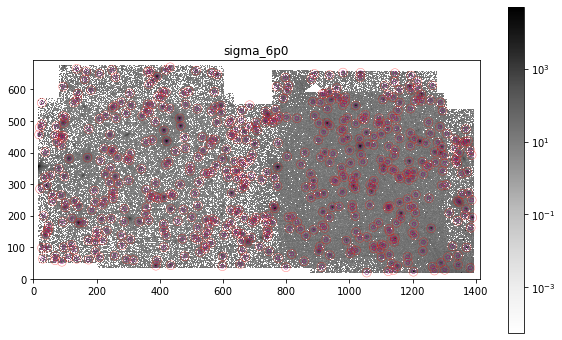

In [22]:
sigma_level = 6.

# 4 sigma seems ideal to me
# fwhm = 3. is roughly the average of many stars tested with imexam (using 1d gaussian fit)
# vicky uses radial fwhm, which varies between 4 - 6 ish; mean is ~4.9, so i'll try 5
# i like the roundness limits at +/- 0.5 personally

#daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5.)
daofind = DAOStarFinder(threshold = sigma_level * std, fwhm = 5., roundlo = -0.5, roundhi = 0.5)
sources = daofind(data - median)   # think: do i need to subtract bkg here? or later?

pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(pos, r=6.)
annuli = CircularAnnulus(pos, r_in=6., r_out=14.)
all_apers = [apertures, annuli]
norm = LogNorm()
plt.imshow(data, cmap='Greys', origin='lower', norm=norm, interpolation='nearest')
plt.colorbar()
apertures.plot(color='blue', lw=.5, alpha=.5)
annuli.plot(color='red', lw=.5, alpha=.5)
plt.gcf().set_size_inches(10, 6)

plotname = str(int(sigma_level)) + 'p' + str(int(10 * (sigma_level - int(sigma_level))))
plt.title('sigma_' + plotname)
#plt.savefig('images/sigma_' + plotname, dpi=500)
plt.savefig('images/yikes_e9.png', dpi=800)

print(len(sources))

Performing some basic aperture photometry, summing the pixel brightness values (fluxes?) inside each aperture and annulus:

(Note: 'nan' values for apertures are where the objects are too close to the edge of the image and use some pure white in their summation, and those for the annuli are where annuli overlap)

In [23]:
phot_table = aperture_photometry(data, all_apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  aperture_sum_0 aperture_sum_1
       pix       pix                                 
--- --------- --------- -------------- --------------
  1 1054.7887 20.391334            nan            nan
  2 1202.6284 23.078684            nan            nan
  3 1122.9374 24.809937      1672.0986            nan
  4 1269.0904 26.909186       6763.025            nan
  5 1139.7435 28.324083      4229.8905            nan
  6 1301.6992  29.11976      11866.238            nan
  7 1382.9784 35.367733      4957.4886            nan
  8 799.12716 37.300992            nan            nan
  9 911.69648 38.531737      2441.8021      6494.6134
 10 1263.1685 38.910191      5693.7359      19465.723
...       ...       ...            ...            ...
549 1035.1606 653.03797            nan            nan
550 979.68707 653.49731            nan            nan
551 361.43968 655.35047      2348.0948       4990.894
552 167.54726 657.03536      6540.1474      2954.1274
553  369.4683 657.68469     

Estimating the local background in the annuli by finding the mean brightness within:

In [24]:
bkg_mean = phot_table['aperture_sum_1'] / annuli.area
#bkg_sum = bkg_mean * apertures.area
#phot_table['bkg_sum'] = bkg_sum
phot_table['bkg_sum'] = bkg_mean * apertures.area
phot_table['residual_sum_mean'] = phot_table['aperture_sum_0'] - phot_table['bkg_sum']
#phot_table['residual_sum_mean'] = final_sum

#for col in final_data.colnames:
#    final_data[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... aperture_sum_1  bkg_sum  residual_sum_mean
       pix       pix    ...                                           
--- --------- --------- ... -------------- --------- -----------------
  1 1054.7887 20.391334 ...            nan       nan               nan
  2 1202.6284 23.078684 ...            nan       nan               nan
  3 1122.9374 24.809937 ...            nan       nan               nan
  4 1269.0904 26.909186 ...            nan       nan               nan
  5 1139.7435 28.324083 ...            nan       nan               nan
  6 1301.6992  29.11976 ...            nan       nan               nan
  7 1382.9784 35.367733 ...            nan       nan               nan
  8 799.12716 37.300992 ...            nan       nan               nan
  9 911.69648 38.531737 ...      6494.6134  1461.288         980.51412
 10 1263.1685 38.910191 ...      19465.723 4379.7877         1313.9482
...       ...       ... ...            ...       ...               ...
549 10

Alternate method: better stats yay (sigma-clipped median in the annuli):

In [25]:
annulus_masks = annuli.to_mask(method='center') # note: exact would be overkill for local bkg estimation (read ap phot tutorial for explanation)

bkg_median = []
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data > 0]   # create 1d array of pixel values in the mask
    _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(median_sigclip)

bkg_median = np.array(bkg_median)
#phot = aperture_photometry(data, apertures)
phot_table['annulus_median'] = bkg_median
phot_table['aper_bkg'] = bkg_median * apertures.area
phot_table['aper_sum_bkgsub'] = phot_table['aperture_sum_0'] - phot_table['aper_bkg']

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)

 id  xcenter   ycenter  ... annulus_median  aper_bkg aper_sum_bkgsub
       pix       pix    ...                                         
--- --------- --------- ... -------------- --------- ---------------
  1 1054.7887 20.391334 ...      18.171846 2055.1874             nan
  2 1202.6284 23.078684 ...      25.080893 2836.5821             nan
  3 1122.9374 24.809937 ...      21.762363 2461.2653      -789.16672
  4 1269.0904 26.909186 ...      42.619045 4820.1005       1942.9246
  5 1139.7435 28.324083 ...      25.385775 2871.0635       1358.8271
  6 1301.6992  29.11976 ...      65.551327 7413.6804       4452.5575
  7 1382.9784 35.367733 ...      46.063828 5209.6962      -252.20757
  8 799.12716 37.300992 ...      14.341268 1621.9592             nan
  9 911.69648 38.531737 ...      13.233718 1496.6982       945.10391
 10 1263.1685 38.910191 ...      36.773636 4159.0002       1534.7356
...       ...       ... ...            ...       ...             ...
549 1035.1606 653.03797 ...      1

Trying to calculate the apparent magnitudes of each star:

I think the negative 'aper_sum_bkgsub's happen in crowded areas where the annulus counts another star as the background, so the bkg value is larger than the aperture sum, or where the star itself is so dim the bkg est is higher, or a mix of both. Does this mean I need a higher threshold or fwhm to rule out the dim boyos? Who knows

In [30]:
flux_zeromag = 280.9         # from Reach et al 2005, section 5.4; for 3.6 band, = 280.9 +/- 4.1
zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
conv = fluxconv / exptime
negative_sums = []

phot_table['apparent_mag_mean'] = float('NaN')
phot_table['apparent_mag_median'] = float('NaN')   # idk why i have to fill the new column with NaNs first but hey ho it works

for i in range(len(phot_table)):
    if phot_table['residual_sum_mean'][i] >= 0:
        phot_table['apparent_mag_mean'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['residual_sum_mean'][i])
    if phot_table['aper_sum_bkgsub'][i] >= 0:
        phot_table['apparent_mag_median'][i] = zmag - 2.5 * math.log10(aperture_correction * conv * phot_table['aper_sum_bkgsub'][i])
    else:
        negative_sums.append(phot_table['id'][i])

for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
print(phot_table)
#print(negative_sums)

print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_mean'])))
print(np.count_nonzero(~np.isnan(phot_table['apparent_mag_median'])))

print(phot_table['aper_sum_bkgsub'])

 id  xcenter   ycenter  ... apparent_mag_mean apparent_mag_median
       pix       pix    ...                                      
--- --------- --------- ... ----------------- -------------------
  1 1054.7887 20.391334 ...               nan                 nan
  2 1202.6284 23.078684 ...               nan                 nan
  3 1122.9374 24.809937 ...               nan                 nan
  4 1269.0904 26.909186 ...               nan           17.336098
  5 1139.7435 28.324083 ...               nan           17.724328
  6 1301.6992  29.11976 ...               nan           16.435714
  7 1382.9784 35.367733 ...               nan                 nan
  8 799.12716 37.300992 ...               nan                 nan
  9 911.69648 38.531737 ...         18.078603           18.118539
 10 1263.1685 38.910191 ...         17.760792           17.592154
...       ...       ... ...               ...                 ...
549 1035.1606 653.03797 ...               nan                 nan
550 979.68

## Writing to file:

In [15]:
#phot_table['id', 'xcenter', 'ycenter', 'apparent_mag_median'].write('outputs/apphot_test01.txt', format='csv', overwrite=True)

C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Jake\anaconda3\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  2.,  2.,  2.,  1.,  2.,
         2.,  1.,  1.,  0.,  0.,  4.,  1.,  1.,  2.,  0.,  1.,  1.,  1.,
         2.,  2.,  3.,  3.,  3.,  1.,  2.,  1.,  2.,  4.,  3.,  4.,  4.,
         4.,  5.,  3.,  6.,  1.,  1.,  5.,  6.,  2.,  4.,  7.,  3.,  5.,
         5.,  5.,  8.,  6.,  4.,  7.,  9.,  6.,  8.,  7.,  5., 14.,  8.,
        10., 18.,  8., 14.,  1., 10.,  7.,  6., 14., 10., 10.,  6., 14.,
         9.,  6.,  6.,  8., 14.,  4.,  6.,  5.,  5.,  7.,  3.,  7.,  7.,
         8.,  4.,  7.,  3.,  5.,  3.,  2.,  2.,  6.,  0.,  1.,  0.,  0.,
         2.,  0.,  1.,  2.,  0.,  0.,  0.,  3.,  2.,  0.,  1.,  0.,  1.,
         2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  1.,  0.,  0.,  1.,  1.,  0.

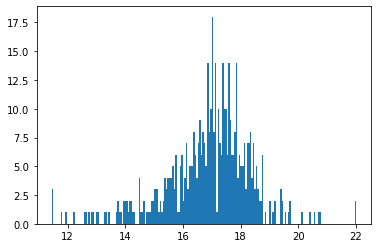

In [16]:
plt.hist(phot_table['apparent_mag_mean'], bins=200)
#plt.hist(phot_table['apparent_mag_median'], bins=200)

In [17]:
#filename_ap = 'outputs/apphot_test01.txt'
#filename_psf = 'outputs/psf_test01.txt'
#file_ap = np.genfromtxt(filename_ap, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)
#file_psf = np.genfromtxt(filename_psf, skip_header=1, delimiter=',', dtype=None, unpack=True, encoding=None)

In [18]:
#print(file_ap)
#print(np.shape(file_ap))

#mag_ap = []
#mag_ap = file_ap[:,3]
#print(mag_ap)

#testy = np.insert(file_ap, )

In [19]:
#t = Table.write(phot_table, 'outputs/table_test_ap.', delimiter=',', format='ascii')